<a href="https://colab.research.google.com/github/flattwhitte/back-up/blob/master/assignment_transfer_l_cifar_10_ipynb_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# CIFAR-10 dataset을 가져옵니다. 그림을 10가지로 분류하는 문제입니다.

from keras.datasets import cifar10 


(x_train, y_train), (x_test, y_test) = cifar10.load_data()


170498071/170498071 [==============================] - 11s 0us/step


In [ ]:
## 그림의 크기가 32x32, 3은 color 사진을 의미합니다.

x_train.shape
     

(50000, 32, 32, 3)

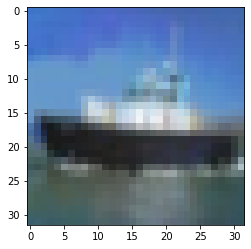

In [ ]:
import matplotlib.pyplot as plt

## 그림 한장을 뽑아 모양을 봅시다.

## 아래 그림은 5번 사진을 뽑았지만, 여러분이 다른 사진을 실험해 보세요.

plt.imshow(x_train[365], cmap = 'gray') ### 여기
plt.show()
     

In [ ]:
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
import numpy as np

### 그림의 픽셀의 숫자를 0부터 1사이로 하기 위해 255로 나누었습니다. 

## 우리 그림의 크기는 32x32x3 임을 잊지 마세요.

### 사실 우리는 x_train과 y_train으로만 실습을 할 예정입니다.

x_train = x_train.reshape(x_train.shape[0], 32, 32, 3).astype('float32') / 255
x_test = x_test.reshape(x_test.shape[0], 32, 32, 3).astype('float32') / 255

y_train = to_categorical(y_train)   ## 정답을 one-hot encoding합니다.
y_test = to_categorical(y_test)


In [ ]:


from tensorflow.keras import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GlobalMaxPool2D, GlobalAveragePooling2D
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.preprocessing.image import ImageDataGenerator

trans_model = ResNet50(include_top=False,  # False로 하여 마지막 soft-max로 이루워진 prediction 부분을 제거합니다.
                 weights="imagenet",
                 input_shape=(32,32,3),    ### 여기
                 ## 이 부분에 우리 그림의 사이즈를 넣어 주세요. 그림 사이즈는 위에서 확인할 수 있어요. 아니면 아래 summary에서도...
                 classes=1000) 



94765736/94765736 [==============================] - 4s 0us/step


In [ ]:
# ResNet50이 어떻게 구성되어 있는지 봅시다.

trans_model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 38, 38, 3)    0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 16, 16, 64)   9472        ['conv1_pad[0][0]']              
                                                                                                  
 conv1_bn (BatchNormalization)  (None, 16, 16, 64)   256         ['conv1_conv[0][0]']             
                                                                                           

In [ ]:
### trans_model은 pretrain이 된 ResNet부분이고, 
### 학습하기에는 너무 거대합니다. 그렇다면 학습을 못하게 해야 합니다.

trans_model.trainable = False ### 여기 

from keras.layers import Dense, Flatten, Activation, Dropout
from keras.models import Sequential

model= Sequential()

model.add(trans_model) ### ResNet부분인 trans_model을 여기에 넣었습니다.
model.add(Flatten())

### 여러분이 원하는 모양으로 해 보세요.
model.add(Dropout(0.44))

model.add(Dense(128))
model.add(Activation('relu'))

model.add(Dense(10))
model.add(Activation('softmax'))##  이것은 10개로 분류하는 모델이라는 것 잊지 마세요.


model.summary()

Model: "sequential_27"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 1, 1, 2048)        23587712  
                                                                 
 flatten_26 (Flatten)        (None, 2048)              0         
                                                                 
 dropout_21 (Dropout)        (None, 2048)              0         
                                                                 
 dense_30 (Dense)            (None, 128)               262272    
                                                                 
 activation_24 (Activation)  (None, 128)               0         
                                                                 
 dense_31 (Dense)            (None, 10)                1290      
                                                                 
 activation_25 (Activation)  (None, 10)              

In [ ]:
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [ ]:
model.fit(x_train, y_train, epochs=3, batch_size=100, verbose=1) ## 여기

early_stopping_callback = EarlyStopping(monitor='var_loss',patience=5)

### verbose=0을 하면 컴퓨터 혼자 묵묵히 일을 하고, verbose=1을 하면 일의 진행상황을 확인할 수 있어요.
### 자료가 크기 때문에, epochs =3, batch_size를 200으로 했는데, epoch마다 약 3분 정도씩 소요되었습니다.
### 이런 점 잘 고려해 보고 실행해 보세요.


Epoch 1/3
500/500 [==============================] - 206s 403ms/step - loss: 2.2550 - accuracy: 0.1682
Epoch 2/3
500/500 [==============================] - 219s 439ms/step - loss: 2.1061 - accuracy: 0.2211
Epoch 3/3
500/500 [==============================] - 221s 441ms/step - loss: 2.0766 - accuracy: 0.2340
